In [1]:
import findiff
from findiff import FinDiff
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from findiff import FinDiff, PDE, BoundaryConditions, Coef
from findiff.diff import Id
from scipy.sparse.linalg import eigs as find_eigs

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
x, y = [np.linspace(0, 1, 10)] *2
X, Y = np.meshgrid(x, y, indexing='ij')
u = np.identity((len(x)))
laplace_2d = FinDiff(0, x[1]-x[0], 2) + FinDiff(1, y[1]-y[0], 2)

# print('this below is what i need')
# print(laplace_2d.matrix(u.shape).toarray())

test = laplace_2d.matrix(u.shape).toarray()

lam_full, u_full = torch.linalg.eigh(torch.tensor(test))

test_rest = test[1:,1:]

lam_res, u_res = torch.linalg.eigh(torch.tensor(test_rest))

print(u_res.shape)

count = 0
for row_res, row_full in zip(u_res, u_full):
    if np.abs(row_full[2].item() - row_full[0].item()) < 0.0000000001:
        count+=1


# stencil = laplace_2d.stencil(u.shape)
# This here seems useless atm idk
# print(len(stencil.data))

# print(stencil.apply_all(u)/324)

torch.Size([99, 99])


In [3]:
def make_laplace_1d(shape : tuple, dt : float):
    if not isinstance(shape, tuple):
        shape = (shape[0], shape[0])
    assert shape[0] >=4, "Cannot do less than 4x4 apparently"
    L = FinDiff(0,dt,2)
    
    #I do shape + 2 in order to make the rectangle boundary one larger in each direction
    return L.stencil(shape = (np.max(shape)+2, np.max(shape) + 2)).apply_all(np.eye(np.max(shape)+2))

shape = (300, )
t = np.linspace(0, 10, shape[0])
dt = t[1]-t[0]

ALPHA = 3
OMEGA = 2
LAMBDA = 0

laplace_1d = FinDiff(0,dt,2)

L = FinDiff(0, dt, 2) - Coef(ALPHA)*FinDiff(0, dt, 1) + Coef(OMEGA**2)*Id()

f = np.sin(t)

bc = BoundaryConditions(shape)
# bc[0] = 0
# bc[-1] = 0
bc[1] = FinDiff(0, dt, 1), 0
# bc[-2] = FinDiff(0, dt, 1), 0
# bc[0] = 0
bc[-1] = -np.sin(10)
pde = PDE(laplace_1d, f, bc)
u_true = pde.solve()

lapl_mat = make_laplace_1d(shape, dt)
lapl_res = lapl_mat[1:,1:]
lam_res, u_res = find_eigs(lapl_res)


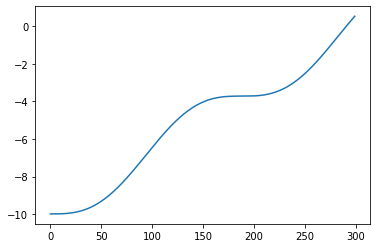

In [4]:
plt.plot(u_true)


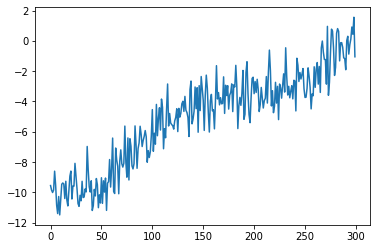

In [5]:
y = u_true + np.random.normal(size = shape)
plt.plot(y)

In [6]:
sample_indices = np.random.choice(np.arange(0,300), size = 20)
# sample_indices = np.arange(50)
train_x = torch.Tensor(t[sample_indices])
# True function is sin(2*pi*x) with Gaussian noise
y_train = y
train_y = torch.Tensor(y_train[sample_indices])

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel = None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [7]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

In [8]:
# f_preds = model(train_x)
# y_preds = likelihood(model(train_x))

# f_mean = f_preds.mean
# f_var = f_preds.variance
# f_covar = f_preds.covariance_matrix
# f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))

In [9]:
true_func = u_true

def plot(observed_pred, train_x, train_y, test_x=torch.linspace(0, 10, 300), true_func = None):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(9, 9))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        
        if true_func is not None:
            # Plot true function if exists
            ax.plot(test_x.numpy(), true_func, 'green')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-15, 8])
        legend = ['Observed Data', 'Mean', 'True function', 'Confidence']
        ax.legend(legend if true_func is not None else legend[~2])
    
# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function, 
# so that we do not have to repeat the code later on
def train(model, train_x, train_y, likelihood, training_iter=training_iter, verbose = True):
   # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


In [14]:
class BCKernel(gpytorch.kernels.Kernel):
    def __init__(self, domain, dirichlet = None, neumann = None,
                 nu_prior = None, nu_constraint = None, **kwargs):
        super().__init__(**kwargs)
        
        self.domain = domain if torch.is_tensor(domain) else torch.as_tensor(domain)
        
        #Only 2 dimension at the moment
        self.dimension = 1 if len(domain.shape) == 1 else domain.shape[1]
        # self.nu = torch.tensor(2.5, requires_grad = True)
        
        self._register_nu(nu_constraint, nu_prior)
        
        #I dont know what self.batch_shape is but eh
        # print(str(*self.batch_shape) + "<-- this is batch_shape")
        
        self.res_domain = self.domain.clone()
        
        
        
        
        #Restrict the domain
        if neumann is not None:
            res_ix = [slice(self.domain.shape[i] - 1) for i in range(len(self.domain.shape))]
            self.res_domain = self.domain[tuple(res_ix)]
            
        # Hard coded for now!! TODO: Make more general for more dimensions
        dt = domain[1] - domain[0]
        lapl_mat = make_laplace_1d(self.res_domain.shape, dt)
        self.L = lapl_mat
        # Get the eigenvalues and eigenvectors of the restricted domain
        self.lam_res, self.u_res = torch.linalg.eigh(torch.tensor(self.L))
        
        if neumann is not None:
            res_ix = [slice(self.domain.shape[i] + 1) for i in range(len(self.domain.shape))]
            self.lam_full= torch.zeros([self.domain.shape[i] + 2 for i in range(len(self.domain.shape))])
            self.lam_full[tuple(res_ix)] = self.lam_res
            self.u_full = torch.zeros(tuple(np.array(self.u_res.shape) + 1))
            self.u_full[res_ix * 2] = self.u_res
        else:
            self.lam_full, self.u_full = self.lam_res, self.u_res
            
        
        
    # now set up the 'actual' paramter
    @property
    def nu(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_nu_constraint.transform(self.raw_nu)

    @nu.setter
    def nu(self, value):
        return self._set_nu(value)

    def _set_nu(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_nu)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_nu=self.raw_nu_constraint.inverse_transform(value))
    
    # the BCkernel is stationary and has lengthscale
    is_stationary = True
    has_lengthscale = True
    
    def _register_nu(self, nu_constraint, nu_prior):
        self.register_parameter(
            name='raw_nu', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        
        
        if nu_constraint is None:
            nu_constraint = gpytorch.constraints.Positive()

        # register the constraint
        self.register_constraint("raw_nu", nu_constraint)
        
        # set the parameter prior, see
        # https://docs.gpytorch.ai/en/latest/module.html#gpytorch.Module.register_prior
        if nu_prior is not None:
            self.register_prior(
                "nu_prior",
                nu_prior,
                lambda m: m.nu,
                lambda m, v : m._set_nu(v),
            )
    
    # this is the kernel function
    def forward(self, x1, x2, **params):
        spec_eigvals = self._compute_spectral(self.lam_full, **params)
        ind_x1 = []
        for xi in x1:
            ix_x1 = torch.where(torch.abs(self.domain - xi) < 1e-6)
            ind_x1.append(ix_x1[0])
            if len(ix_x1[0]) > 1:
                print("Warning! multiple matches found for domain should not happen!")
        
        ind_x2 = []
        for xi in x2:
            ix_x2 = torch.where(torch.abs(self.domain - xi) < 1e-6)
            ind_x2.append(ix_x2[0])
            if len(ix_x2[0]) > 1:
                print("Warning! multiple matches found for domain should not happen!")
        
        ind_x1 = torch.concat(ind_x1)
        ind_x2 = torch.concat(ind_x2)
        
        #I need index!!
        return self.u_full[ind_x1] @ (spec_eigvals*torch.eye(spec_eigvals.flatten().shape[0])) @ self.u_full[ind_x2].T
    
    def _compute_spectral(self, eigvals, **params):
        d = self.dimension if torch.is_tensor(self.dimension) else torch.as_tensor(self.dimension)
        l = self.lengthscale
        v = self.nu
        var_f = likelihood.noise
        
        gamma_term = torch.exp(torch.lgamma(v + d/2) - torch.lgamma(v))
        const_term = 2**d * torch.pi ** (d/2) * (2*v)**v / l**(2*v)
        foo = (2*v/torch.pow(l,2) + torch.pow(eigvals,2))
        spectral = var_f * gamma_term * const_term * torch.pow((2*v/l**2 + eigvals**2), -(2*v+d)/2)
        return spectral
        

Iter 1/50 - Loss: 6.054   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 5.460   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 4.955   lengthscale: 0.798   noise: 0.798
Iter 4/50 - Loss: 4.529   lengthscale: 0.853   noise: 0.852
Iter 5/50 - Loss: 4.170   lengthscale: 0.910   noise: 0.907
Iter 6/50 - Loss: 3.867   lengthscale: 0.967   noise: 0.962
Iter 7/50 - Loss: 3.613   lengthscale: 1.025   noise: 1.016
Iter 8/50 - Loss: 3.399   lengthscale: 1.084   noise: 1.069
Iter 9/50 - Loss: 3.219   lengthscale: 1.142   noise: 1.121
Iter 10/50 - Loss: 3.067   lengthscale: 1.200   noise: 1.170
Iter 11/50 - Loss: 2.937   lengthscale: 1.257   noise: 1.217
Iter 12/50 - Loss: 2.828   lengthscale: 1.313   noise: 1.261
Iter 13/50 - Loss: 2.734   lengthscale: 1.367   noise: 1.302
Iter 14/50 - Loss: 2.653   lengthscale: 1.420   noise: 1.340
Iter 15/50 - Loss: 2.583   lengthscale: 1.471   noise: 1.374
Iter 16/50 - Loss: 2.523   lengthscale: 1.520   noise: 1.405
Iter 17/50 - Loss: 2.470   length

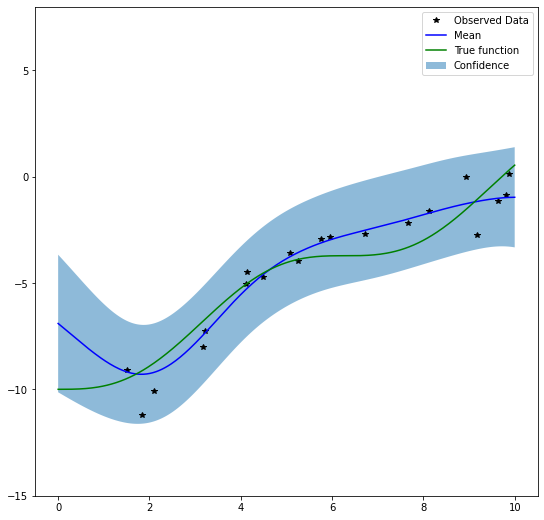

In [15]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
model.train()
likelihood.train()
train(model, train_x, train_y, likelihood, verbose = True)
model.eval()
likelihood.eval()
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 10, 300)
    observed_pred = likelihood(model(test_x))
# observed_pred = predict(model, likelihood, test_x)
plot(observed_pred, train_x, train_y, true_func = u_true)

In [18]:
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
model2 = ExactGPModel(train_x, train_y, likelihood2)
model2.covar_module = gpytorch.kernels.ScaleKernel(BCKernel(t, dirichlet = {10 : 0}, neumann = {0 : 0}))
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
model2.train()
likelihood2.train()
train(model2, train_x, train_y, likelihood2, verbose = True)
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
Parameter name: covar_module.base_kernel.raw_nu            value = 0.0
Iter 1/50 - Loss: 19.262   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 17.401   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 15.761   lengthscale: 0.798   noise: 0.798
Iter 4/50 - Loss: 14.318   lengthscale: 0.854   noise: 0.853
Iter 5/50 - Loss: 13.050   lengthscale: 0.912   noise: 0.910
Iter 6/50 - Loss: 11.936   lengthscale: 0.971   noise: 0.968
Iter 7/50 - Loss: 10.960   lengthscale: 1.033   noise: 1.027
Iter 8/50 - Loss: 10.102   lengthscale: 1.096   noise: 1.086
Iter 9/50 - Loss: 9.350   lengthscale: 1.159   noise: 1.146
Iter 10/50 - Loss: 8.689   lengthscale: 1.224   noise: 1.205
Iter 11/50 - Loss: 8.107   lengthsca

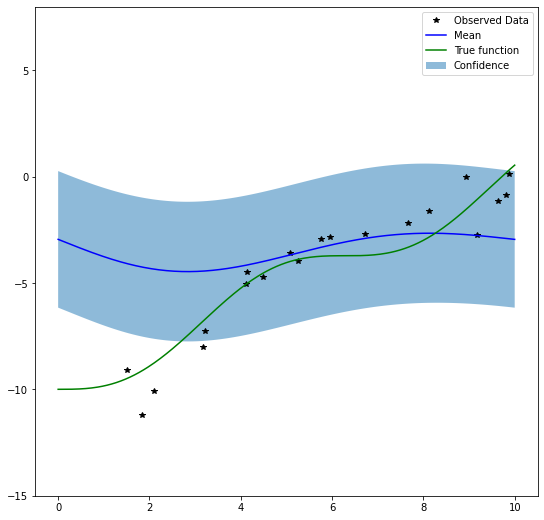

In [17]:
model2.eval()
likelihood2.eval()
observed_pred2 = predict(model2, likelihood2, test_x)
plot(observed_pred2, train_x, train_y, true_func = u_true)